# Task 1: Data Understanding and Visualization:
## 1. Load and visualize images from a dataset stored in directories, where each subdirec-tory represents a class.

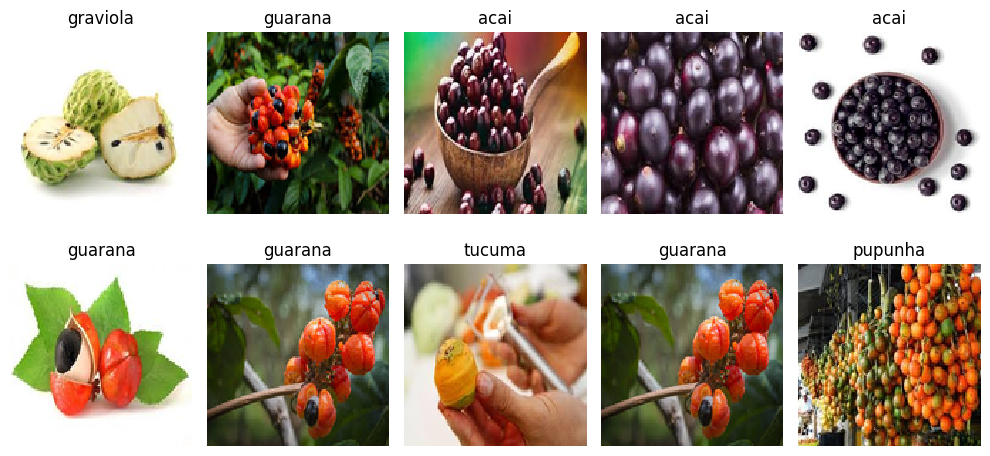

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Training and testing directory
train_dir = "/content/drive/MyDrive/AIandML/Worksheet5/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AIandML/Worksheet5/FruitinAmazon/FruitinAmazon/test"

img_height, img_width = 128, 128  # Increased resolution

def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Ensure consistent label order
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.resize((img_width, img_height), Image.LANCZOS)  # LANCZOS for sharper resizing
                images.append(np.array(img))
                labels.append(class_dict[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names
# Load training images
X, y, class_names = load_images_from_directory(train_dir)

# Normalize pixel values to [0,1]
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, num_classes=len(class_names))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Display some sample images
def display_sample_images(X, y, class_names, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    axes = axes.flatten()

    for i in range(rows * cols):
        idx = np.random.randint(len(X))
        axes[i].imshow(X[idx], interpolation='nearest')  # Ensure sharp display
        axes[i].set_title(class_names[np.argmax(y[idx])])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Display sample images from training set
display_sample_images(X_train, y_train, class_names)

# 2. Check for Corrupted Image:

In [4]:
import os
from PIL import Image

def check_and_remove_corrupted_images(directory):
    corrupted_images = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    # Verify image format
                    img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_images.append(img_path)
                os.remove(img_path)
                print(f"Removed corrupted image: {img_path}")
    if not corrupted_images:
        print("No corrupted images found.")
    return corrupted_images

# Call the function to check and remove corrupted images from the train directory
corrupted_images = check_and_remove_corrupted_images(train_dir)

No corrupted images found.


# Task 2: Loading and Preprocessing Image Data in keras:

In [7]:
# Define image size and batch size
img_height = 128
img_width = 128
batch_size = 32
validation_split=0.2 #80% training , 20% validation
# Create preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0,1]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
    )

# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# Task 3 - Implement a CNN with

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the CNN + Fully Connected Network model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))

# Max Pooling Layer 1
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Convolutional Layer 2
model.add(Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))

# Max Pooling Layer 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Hidden Layer 1 - 64 neurons
model.add(Dense(64, activation='relu'))

# Hidden Layer 2 - 128 neurons
model.add(Dense(128, activation='relu'))
# Output Layer (Number of classes = len(class_names))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

Explanation of the Layers: Convolutional Layers (Conv2D) and Max Pooling Layers (MaxPooling2D): These layers are the same as in the previous CNN model. They extract features from the image and reduce spatial dimensions.

Flatten Layer:

The Flatten() layer reshapes the output from the convolutional layers into a 1D vector that can be passed to the fully connected layers.

Hidden Layers:

Dense Layer 1: Has 64 neurons, with ReLU activation. This layer learns the relationships between the features extracted by the convolutional layers.

Dense Layer 2: Has 128 neurons, also with ReLU activation. This further processes the features learned in the first hidden layer.

Output Layer:

The number of neurons is equal to the number of classes (i.e., len(class_names)).

Softmax activation is used for multi-class classification, where the model outputs probabilities for each class.

Model Compilation: Optimizer: Adam optimizer is used for gradient descent.

Loss function: categorical_crossentropy is used for multi-class classification.

Metrics: Accuracy is used to evaluate the model's performance.

# Task 4: Compile the Model

In [15]:
# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']  # Accuracy metric
)

# Task 4: Train the Model

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
# ModelCheckpoint: Save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',  # File path to save the best model
    monitor='val_loss',  # Monitor validation loss (could also use 'val_accuracy')
    save_best_only=True,  # Save only the best model
    mode='min',  # Minimize the validation loss
    verbose=1  # Print a message when the model is saved
)

# EarlyStopping: Stop training if validation loss doesn't improve for a given number of epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the weights of the best model
    verbose=1  # Print a message when training stops
)

# Train the model using model.fit() with callbacks
history = model.fit(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[checkpoint_callback, early_stopping_callback]  # Callbacks for saving the best model and early stopping
)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.2021 - loss: 2.3815
Epoch 1: val_loss improved from inf to 1.71304, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1962 - loss: 2.3900 - val_accuracy: 0.1667 - val_loss: 1.7130
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2264 - loss: 1.7471
Epoch 2: val_loss did not improve from 1.71304
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.2350 - loss: 1.7434 - val_accuracy: 0.1111 - val_loss: 1.7494
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4156 - loss: 1.5631
Epoch 3: val_loss improved from 1.71304 to 1.56100, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.4089 - loss: 1.5678 - val_accuracy: 0.3889 - val_loss: 1.5610
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3844 - loss: 1.3983
Epoch 4: val_loss improved from 1.56100 to 1.45880, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.3898 - loss: 1.3910 - val_accuracy: 0.3889 - val_loss: 1.4588
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5420 - loss: 1.1139
Epoch 5: val_loss improved from 1.45880 to 1.32089, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.5466 - loss: 1.1061 - val_accuracy: 0.3889 - val_loss: 1.3209
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7667 - loss: 0.7893
Epoch 6: val_loss improved from 1.32089 to 1.14539, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.7708 - loss: 0.7839 - val_accuracy: 0.5000 - val_loss: 1.1454
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8542 - loss: 0.5196
Epoch 7: val_loss improved from 1.14539 to 1.04672, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.8507 - loss: 0.5148 - val_accuracy: 0.4444 - val_loss: 1.0467
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9104 - loss: 0.3357
Epoch 8: val_loss improved from 1.04672 to 1.04416, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9115 - loss: 0.3319 - val_accuracy: 0.6111 - val_loss: 1.0442
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9444 - loss: 0.2096
Epoch 9: val_loss improved from 1.04416 to 1.02126, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9421 - loss: 0.2119 - val_accuracy: 0.5556 - val_loss: 1.0213
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 1.0000 - loss: 0.1399
Epoch 10: val_loss did not improve from 1.02126
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 494ms/step - accuracy: 1.0000 - loss: 0.1390 - val_accuracy: 0.5000 - val_loss: 1.3534
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9941 - loss: 0.0783
Epoch 11: val_loss did not improve from 1.02126
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.9928 - loss: 0.0790 - val_accuracy: 0.5556 - val_loss: 1.2620
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 1.0000 - loss: 0.0330
Epoch 12: val_loss did not improve from 1.02126
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 1.0000 - loss: 0.0340 - val_accuracy: 0.5556 - val_loss: 1.0521
Epoch 13/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 1.0000 - loss: 0.0238
Epoch 13: val_loss did not improve from 1.02126
5/5 

In [17]:
# Remove one-hot encoding (to_categorical)
X, y, class_names = load_images_from_directory(train_dir)

# Normalize pixel values to [0,1]
X = X / 255.0

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Compilation using sparse_categorical_crossentropy
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']  # Accuracy metric
)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',  # File path to save the best model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # Minimize the validation loss
    verbose=1  # Print a message when the model is saved
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the weights of the best model
    verbose=1  # Print a message when training stops
)
# Train the model using model.fit() with callbacks
history = model.fit(
    X_train,  # Training data
    y_train,  # Training labels
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[checkpoint_callback, early_stopping_callback]  # Callbacks for saving the best model and early stopping
)


Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9292 - loss: 0.3060
Epoch 1: val_loss improved from inf to 1.50175, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.9271 - loss: 0.3095 - val_accuracy: 0.3333 - val_loss: 1.5018
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9424 - loss: 0.2671
Epoch 2: val_loss improved from 1.50175 to 0.88818, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 0.9473 - loss: 0.2629 - val_accuracy: 0.7222 - val_loss: 0.8882
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9635 - loss: 0.1907
Epoch 3: val_loss did not improve from 0.88818
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.9627 - loss: 0.1947 - val_accuracy: 0.5556 - val_loss: 1.0859
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 1.0000 - loss: 0.0641
Epoch 4: val_loss did not improve from 0.88818
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 1.0000 - loss: 0.0654 - val_accuracy: 0.4444 - val_loss: 1.6526
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 1.0000 - loss: 0.0355
Epoch 5: val_loss did not improve from 0.88818
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 1.0000 - loss: 0.0336 - val_accuracy: 0.5000 - val_loss: 1.2564
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 1.0000 - loss: 0.0128
Epoch 6: val_loss did not improve from 0.88818
5/5 ━━━━━━━━

# Task 5: Evaluate the Model

In [18]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the test data (assuming the test data is in a similar format to the training data)
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),  # Ensure test images are resized to match training images
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Apply normalization to the test dataset (same as training and validation datasets)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5667 - loss: 1.1622
Test Loss: 1.1621696949005127
Test Accuracy: 0.5666666626930237


In [19]:
# Save the model to an .h5 file
model.save('my_model.keras')

In [20]:
from tensorflow.keras.models import load_model

# Load the model in the Keras format
loaded_model = load_model('my_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
# Evaluate the loaded model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_ds)

# Print the results
print(f"Test Loss (after reloading): {test_loss}")
print(f"Test Accuracy (after reloading): {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - accuracy: 0.5667 - loss: 1.1622
Test Loss (after reloading): 1.1621696949005127
Test Accuracy (after reloading): 0.5666666626930237


# Task 7: Predictions and Classification Repo

In [23]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
import os

# Get class names from the directory structure
class_names = sorted(os.listdir(test_dir))  # List of class names

# Get the test dataset (make sure it's in the same format as train_ds)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Get true labels from the test dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Make predictions on the test dataset
predictions = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)

# Ensure true_labels and predicted_labels are 1D arrays
true_labels = true_labels.flatten()
predicted_labels = predicted_labels.flatten()

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
              precision    recall  f1-score   support

        acai       0.62      1.00      0.77         5
     cupuacu       1.00      0.40      0.57         5
    graviola       0.44      0.80      0.57         5
     guarana       1.00      0.60      0.75         5
     pupunha       0.71      1.00      0.83         5
      tucuma       1.00      0.20      0.33         5

    accuracy                           0.67        30
   macro avg       0.80      0.67      0.64        30
weighted avg       0.80      0.67      0.64        30



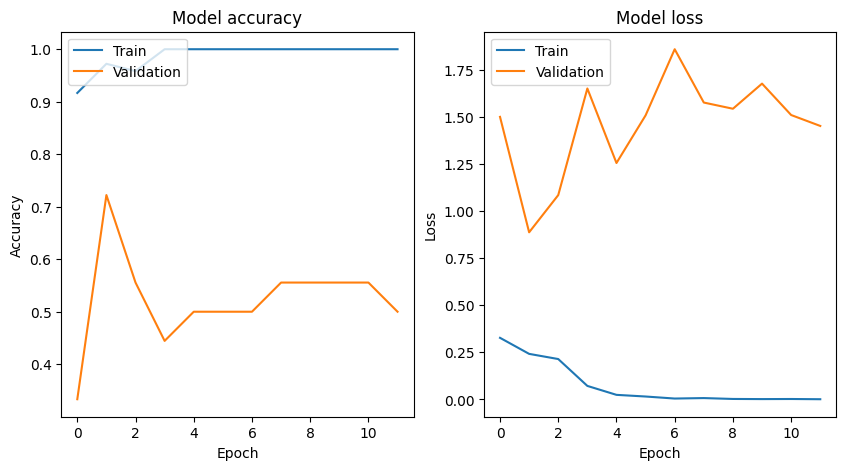

In [24]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
